# SST gradient trends

This Jupyter notebook shows how to compute the SST gradient trend maps reported in the manuscript "Global changes in oceanic mesoscale currents over the satellite altimetry record".

In [1]:
# Import libraries
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs

import pylab as plt
import numpy as np
# Inline plotting
%matplotlib inline

#### Import Mann Kendall test:

In [2]:
from xarrayMannKendall import Mann_Kendall_test

In [3]:
from utils import area,ccrs_land,add_patches
import datetime as datetime

In [4]:
from dask.distributed import Client

In [5]:
c = Client()
c

Client Scheduler: tcp://127.0.0.1:38127 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 36 Memory: 154.62 GB


In [6]:
dataset_SST = xr.open_dataset('../datasets/SST_grad_timeseries.nc',chunks={'lat':10,'lon':10})

In [7]:
SST_timeseries = dataset_SST.SST

In [8]:
SST = SST_timeseries.sortby('time').sel(time=slice('1993','2020'))

In [9]:
SST

,Array,Chunk
Bytes,2.65 GB,4.09 MB
Shape,"(10227, 180, 360)","(10227, 10, 10)"
Count,1297 Tasks,648 Chunks
Type,float32,numpy.ndarray


In [10]:
# Print function used.
?Mann_Kendall_test

Init signature:
Mann_Kendall_test(
    DataArray,
    dim='time',
    alpha=0.01,
    MK_modified=False,
    method='linregress',
    coords_name=None,
)
Docstring:     
Compute linear trends and significance using Mann Kendall test.

Parameters
----------
DataArray : xarray.DataArray
    Dataset to analyse.
dim : str
    Coordiante name in which the linear trend will apply ('time').
alpha: float
    Significance level (default = 0.01)
MK_modified: Boolean
    Modified Mann-Kendall using Yue and Wang (2004) method.
    DOI: https://doi.org/10.1023/B:WARM.0000043140.61082.60
method: str
    Method for linear regresion: linregress (default) and theilslopes
coords_name: dict
    Coordinates name dict renames coordinates to 'lon','lat'. 
    Example:   
        coords_name={'xu_ocean':'lon','yu_ocean':'lat','t':time}
        
Example:

    # Time series length
    n=100
    time = np.arange(n)
    # Grid
    x = np.arange(4)
    y = np.arange(4)
    
    # Create dataarray
    data = np.ze

For more information in the Mann-Kendall method, please refer to: https://doi.org/10.1023/B:WARM.0000043140.61082.60

The reported trends use a modified Mann-Kendall method. A modified Mann-Kendall test is used to assess statistical significance of trends, while properly taking into account the autocorrelation in the time-series. The effective sample size for all the reported trends is always smaller than the actual sample size, due to autocorrelation of the time series. 

In [11]:
sst_trends = Mann_Kendall_test(SST,'time',MK_modified=True,
                               method="linregress",alpha=0.05, 
                               coords_name = {'time':'time','x':'lon','y':'lat'})

Note that the following cell will take ~1 hour depending on the number of cores, as the Mann-Kendall method requirest to invert a matrix of shape (len(time),len(time)) for each grid point.

In [12]:
sst_grad = sst_trends.compute()

In [13]:
sst_grad.attrs['title'] = "Sea Surface Temperature gradients trends"
sst_grad.attrs['Description'] = """SST gradients computed from OISST-NOAA. Then trends were computed using a modified Mann-Kendall test. \n See: https://github.com/josuemtzmo/xarrayMannKendall."""
sst_grad.attrs['Publication'] = "Dataset created for Martínez-Moreno, J. et. al. 2020: \n 'Mesoscale kinetic energy response to changing oceans'"
sst_grad.attrs['Author'] = "Josué Martínez-Moreno"
sst_grad.attrs['Contact'] = "josue.martinezmoreno@anu.edu.au"

sst_grad.attrs['Created date'] = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")

######################################################

sst_grad['trend'].attrs['units'] = r"$^\circ C m^{-1} day^{-1}$"
sst_grad['trend'].attrs['name'] = 'trend'
sst_grad['trend'].attrs['long_name'] = "Sea Surface Temperature gradients trends"

sst_grad['trend'].attrs['missing_value'] = np.nan
sst_grad['trend'].attrs['valid_min'] = np.nanmin(sst_grad['trend'])
sst_grad['trend'].attrs['valid_max'] = np.nanmax(sst_grad['trend'])
sst_grad['trend'].attrs['valid_range'] = [np.nanmin(sst_grad['trend']),np.nanmax(sst_grad['trend'])]

######################################################

sst_grad['signif'].attrs['units'] = ""
sst_grad['signif'].attrs['name'] = 'signif'
sst_grad['signif'].attrs['long_name'] = "Sea Surface Temperature gradients trends significance"

sst_grad['signif'].attrs['missing_value'] = np.nan
sst_grad['signif'].attrs['valid_min'] = np.nanmin(sst_grad['signif'])
sst_grad['signif'].attrs['valid_max'] = np.nanmax(sst_grad['signif'])
sst_grad['signif'].attrs['valid_range'] = [np.nanmin(sst_grad['signif']),np.nanmax(sst_grad['signif'])]

######################################################

sst_grad['p'].attrs['units'] = ""
sst_grad['p'].attrs['name'] = 'p'
sst_grad['p'].attrs['long_name'] = "Sea Surface Temperature gradients trends p"

sst_grad['p'].attrs['missing_value'] = np.nan
sst_grad['p'].attrs['valid_min'] = np.nanmin(sst_grad['p'])
sst_grad['p'].attrs['valid_max'] = np.nanmax(sst_grad['p'])
sst_grad['p'].attrs['valid_range'] = [np.nanmin(sst_grad['p']),np.nanmax(sst_grad['p'])]

In [14]:
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in sst_grad.data_vars}

sst_grad.to_netcdf('../datasets/SST_grads_trends.nc', encoding=encoding)

In [15]:
trends = sst_grad.trend*10*365 # Convert to trends per decade

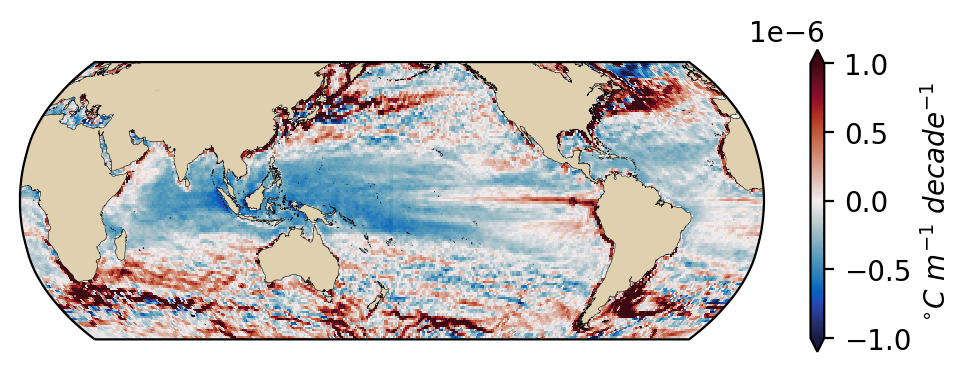

In [16]:
fig = plt.figure(figsize=(6,2), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude=180))

im = trends.plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(label="$^{\circ}C\ m^{-1}\ decade^{-1}$"),
              cmap=cm.cm.balance, vmin=-1e-6, vmax=1e-6,ax=ax)
ax.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax.add_feature(ccrs_land)
add_patches(ax)


## Mesoscale SST gradients trends

In [17]:
dataset_SST_scales = xr.open_dataset('../datasets/SST_grads_decomposition_timeseries.nc',chunks={'lat':10,'lon':10})

In [18]:
SST_small_timeseries = dataset_SST_scales.SST_grad_small_scale

In [19]:
SST_small = SST_small_timeseries.sortby('time').sel(time=slice('1993','2020'))

In [20]:
sst_small_trends = Mann_Kendall_test(SST_small,'time',MK_modified=True,
                               method="linregress",alpha=0.05, 
                               coords_name = {'time':'time','x':'lon','y':'lat'})

In [21]:
small_sst_grad = sst_small_trends.compute()

In [22]:
small_sst_grad.attrs['title'] = "Mesoscale Sea Surface Temperature gradients trends"
small_sst_grad.attrs['Description'] = """Mesoscale SST gradients computed from OISST-NOAA. Then trends were computed using a modified Mann-Kendall test. \n See: https://github.com/josuemtzmo/xarrayMannKendall."""
small_sst_grad.attrs['Publication'] = "Dataset created for Martínez-Moreno, J. et. al. 2020: \n 'Mesoscale kinetic energy response to changing oceans'"
small_sst_grad.attrs['Author'] = "Josué Martínez-Moreno"
small_sst_grad.attrs['Contact'] = "josue.martinezmoreno@anu.edu.au"

small_sst_grad.attrs['Created date'] = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")

######################################################

small_sst_grad['trend'].attrs['units'] = r"$^\circ C m^{-1} day^{-1}$"
small_sst_grad['trend'].attrs['name'] = 'trend'
small_sst_grad['trend'].attrs['long_name'] = "Mesoscale Sea Surface Temperature gradients trends"

small_sst_grad['trend'].attrs['missing_value'] = np.nan
small_sst_grad['trend'].attrs['valid_min'] = np.nanmin(small_sst_grad['trend'])
small_sst_grad['trend'].attrs['valid_max'] = np.nanmax(small_sst_grad['trend'])
small_sst_grad['trend'].attrs['valid_range'] = [np.nanmin(small_sst_grad['trend']),np.nanmax(small_sst_grad['trend'])]

######################################################

small_sst_grad['signif'].attrs['units'] = ""
small_sst_grad['signif'].attrs['name'] = 'signif'
small_sst_grad['signif'].attrs['long_name'] = "Mesoscale Sea Surface Temperature gradients trends significance"

small_sst_grad['signif'].attrs['missing_value'] = np.nan
small_sst_grad['signif'].attrs['valid_min'] = np.nanmin(small_sst_grad['signif'])
small_sst_grad['signif'].attrs['valid_max'] = np.nanmax(small_sst_grad['signif'])
small_sst_grad['signif'].attrs['valid_range'] = [np.nanmin(small_sst_grad['signif']),np.nanmax(small_sst_grad['signif'])]

######################################################

small_sst_grad['p'].attrs['units'] = ""
small_sst_grad['p'].attrs['name'] = 'p'
small_sst_grad['p'].attrs['long_name'] = "Mesoscale Sea Surface Temperature gradients trends p"

small_sst_grad['p'].attrs['missing_value'] = np.nan
small_sst_grad['p'].attrs['valid_min'] = np.nanmin(small_sst_grad['p'])
small_sst_grad['p'].attrs['valid_max'] = np.nanmax(small_sst_grad['p'])
small_sst_grad['p'].attrs['valid_range'] = [np.nanmin(small_sst_grad['p']),np.nanmax(small_sst_grad['p'])]

In [23]:
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in sst_grad.data_vars}

small_sst_grad.to_netcdf('../datasets/mesoscale_SST_grads_trends.nc', encoding=encoding)

In [24]:
trends = small_sst_grad.trend*10*365 # Convert to trends per decade

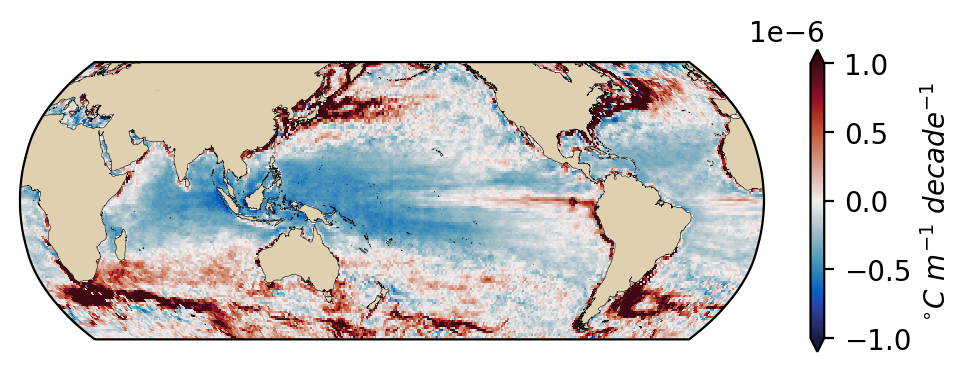

In [25]:
fig = plt.figure(figsize=(6,2), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude=180))

im = trends.plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(label="$^{\circ}C\ m^{-1}\ decade^{-1}$"),
              cmap=cm.cm.balance, vmin=-1e-6, vmax=1e-6,ax=ax)
ax.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax.add_feature(ccrs_land)
add_patches(ax)

## Large scale SST gradient trends

In [26]:
SST_large_timeseries = dataset_SST_scales.SST_grad_large_scale

In [27]:
SST_large = SST_large_timeseries.sortby('time').sel(time=slice('1993','2020'))

In [28]:
sst_large_trends = Mann_Kendall_test(SST_large,'time',MK_modified=True,
                               method="linregress",alpha=0.05, 
                               coords_name = {'time':'time','x':'lon','y':'lat'})

In [29]:
large_sst_grad = sst_large_trends.compute()

In [30]:
large_sst_grad.attrs['title'] = "Large-Scale Sea Surface Temperature gradients trends"
large_sst_grad.attrs['Description'] = """Large-Scale SST gradients computed from OISST-NOAA. Then trends were computed using a modified Mann-Kendall test. \n See: https://github.com/josuemtzmo/xarrayMannKendall."""
large_sst_grad.attrs['Publication'] = "Dataset created for Martínez-Moreno, J. et. al. 2020: \n 'Mesoscale kinetic energy response to changing oceans'"
large_sst_grad.attrs['Author'] = "Josué Martínez-Moreno"
large_sst_grad.attrs['Contact'] = "josue.martinezmoreno@anu.edu.au"

large_sst_grad.attrs['Created date'] = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")

######################################################

large_sst_grad['trend'].attrs['units'] = r"$^\circ C m^{-1} day^{-1}$"
large_sst_grad['trend'].attrs['name'] = 'trend'
large_sst_grad['trend'].attrs['long_name'] = "Large-Scale Sea Surface Temperature gradients trends"

large_sst_grad['trend'].attrs['missing_value'] = np.nan
large_sst_grad['trend'].attrs['valid_min'] = np.nanmin(large_sst_grad['trend'])
large_sst_grad['trend'].attrs['valid_max'] = np.nanmax(large_sst_grad['trend'])
large_sst_grad['trend'].attrs['valid_range'] = [np.nanmin(large_sst_grad['trend']),np.nanmax(large_sst_grad['trend'])]

######################################################

large_sst_grad['signif'].attrs['units'] = ""
large_sst_grad['signif'].attrs['name'] = 'signif'
large_sst_grad['signif'].attrs['long_name'] = "Large-Scale Sea Surface Temperature gradients trends significance"

large_sst_grad['signif'].attrs['missing_value'] = np.nan
large_sst_grad['signif'].attrs['valid_min'] = np.nanmin(large_sst_grad['signif'])
large_sst_grad['signif'].attrs['valid_max'] = np.nanmax(large_sst_grad['signif'])
large_sst_grad['signif'].attrs['valid_range'] = [np.nanmin(large_sst_grad['signif']),np.nanmax(large_sst_grad['signif'])]

######################################################

large_sst_grad['p'].attrs['units'] = ""
large_sst_grad['p'].attrs['name'] = 'p'
large_sst_grad['p'].attrs['long_name'] = "Large-Scale Sea Surface Temperature gradients trends p"

large_sst_grad['p'].attrs['missing_value'] = np.nan
large_sst_grad['p'].attrs['valid_min'] = np.nanmin(large_sst_grad['p'])
large_sst_grad['p'].attrs['valid_max'] = np.nanmax(large_sst_grad['p'])
large_sst_grad['p'].attrs['valid_range'] = [np.nanmin(large_sst_grad['p']),np.nanmax(large_sst_grad['p'])]

In [31]:
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in sst_grad.data_vars}

large_sst_grad.to_netcdf('../datasets/large_scale_SST_grads_trends.nc', encoding=encoding)

In [32]:
trends = large_sst_grad.trend*10*365 # Convert to trends per decade

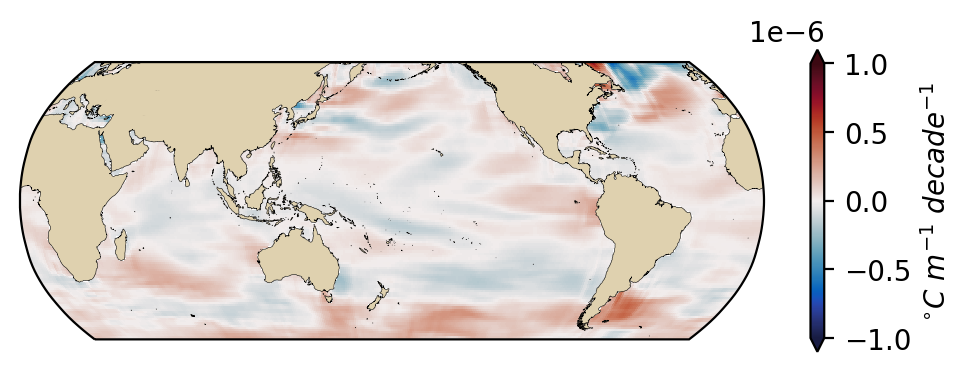

In [33]:
fig = plt.figure(figsize=(6,2), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude=180))

im = trends.plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(label="$^{\circ}C\ m^{-1}\ decade^{-1}$"),
              cmap=cm.cm.balance, vmin=-1e-6, vmax=1e-6,ax=ax)
ax.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax.add_feature(ccrs_land)
add_patches(ax)